# Titanic Classification Exercise

## Setup and Load the data

In [1]:
# Setup

import os
import pandas as pd
import numpy as np

In [2]:
# Load the data

TITANIC_DATA_PATH = os.path.join("datasets", "titanic")

# This function returns a pandas DataFrame object containing all the data.
def load_titanic_data(filename, data_path=TITANIC_DATA_PATH):
    csv_path = os.path.join(data_path, filename)
    return pd.read_csv(csv_path)

training_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")


Note that the test data does not contain the labels, our goal is to train the best model possible on the training data, then make predictions on the test data, and upload the results to Kaggle.com to see our final score.

## Start to explore and understand the data

In [3]:
training_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

The attributes have the following meaning:

- Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
- Pclass: passenger class.
- Name, Sex, Age: self-explanatory
- SibSp: how many siblings & spouses of the passenger aboard the Titanic.
- Parch: how many children & parents of the passenger aboard the Titanic.
- Ticket: ticket id
- Fare: price paid (in pounds)
- Cabin: passenger's cabin number
- Embarked: where the passenger embarked the Titanic

In [4]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Notice: 

Name and Sex are both objects, probably strings. We will probably need to convert these to numerical attributes or drop them (We probably don't need to know the names)

We are missing some values and we will need to deal with those in somehow. We are missing some values for: 
- Age (714/891)
- Cabin (204/891)
- Embarked (889)

I think we should be able to use the median age to fill in the blanks for age, and we can probably drop the 'Cabin' and 'Embarked' categories.

I think we can probably also add a class to combine SibSp and Parch into a Family class.

I think we can also drop the PassengerId class for the row index and just remember that it's offset by 1.

In [5]:
# Let's take a deeper look at the numerical attributes next.
training_data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

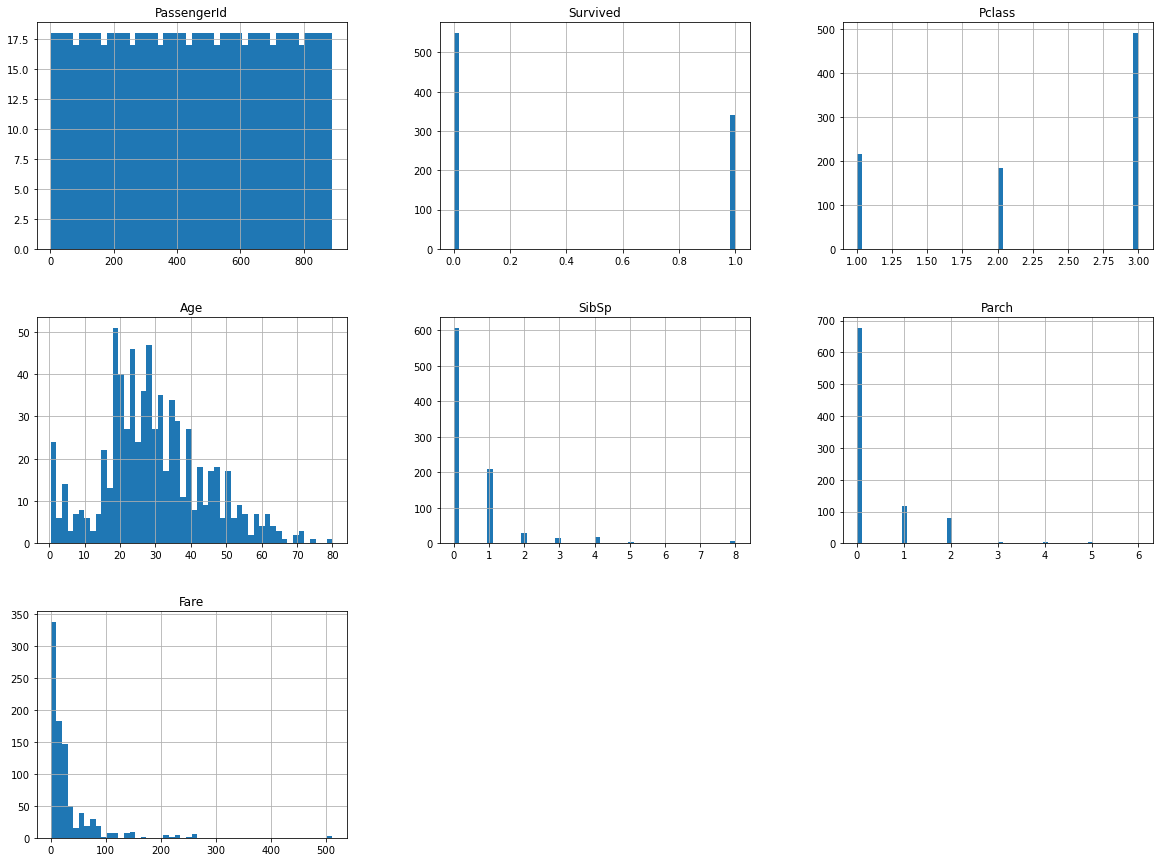

In [6]:
# We can also plot a histogram of each numerical attribute to get a feel for our data
%matplotlib inline
# ^ Jupyter notebook command for inline matplotlib
import matplotlib.pyplot as plt
training_data.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
# Drop unnecessary attributes
training_data = training_data.drop("PassengerId", axis=1)
training_data = training_data.drop("Name", axis=1)
training_data = training_data.drop("Ticket", axis=1)
training_data = training_data.drop("Cabin", axis=1)
training_data = training_data.drop("Embarked", axis=1)
training_data.head()

Survived  Pclass     Sex   Age  SibSp  Parch     Fare
0         0       3    male  22.0      1      0   7.2500
1         1       1  female  38.0      1      0  71.2833
2         1       3  female  26.0      0      0   7.9250
3         1       1  female  35.0      1      0  53.1000
4         0       3    male  35.0      0      0   8.0500

## Discover and Visualize the Data to gain Insights

In [8]:
## Looking for Correlations
# Compute the standard correlation coefficient (Pearson's r) between every pair of attributes
correlation_matrix = training_data.corr()

# Look at how much each attribute correlates with the 'Survived' attribute.
correlation_matrix["Survived"].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

array([[<AxesSubplot:xlabel='Survived', ylabel='Survived'>,
        <AxesSubplot:xlabel='Fare', ylabel='Survived'>,
        <AxesSubplot:xlabel='Parch', ylabel='Survived'>,
        <AxesSubplot:xlabel='SibSp', ylabel='Survived'>,
        <AxesSubplot:xlabel='Age', ylabel='Survived'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Survived'>],
       [<AxesSubplot:xlabel='Survived', ylabel='Fare'>,
        <AxesSubplot:xlabel='Fare', ylabel='Fare'>,
        <AxesSubplot:xlabel='Parch', ylabel='Fare'>,
        <AxesSubplot:xlabel='SibSp', ylabel='Fare'>,
        <AxesSubplot:xlabel='Age', ylabel='Fare'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Fare'>],
       [<AxesSubplot:xlabel='Survived', ylabel='Parch'>,
        <AxesSubplot:xlabel='Fare', ylabel='Parch'>,
        <AxesSubplot:xlabel='Parch', ylabel='Parch'>,
        <AxesSubplot:xlabel='SibSp', ylabel='Parch'>,
        <AxesSubplot:xlabel='Age', ylabel='Parch'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Parch'>],
       [<A

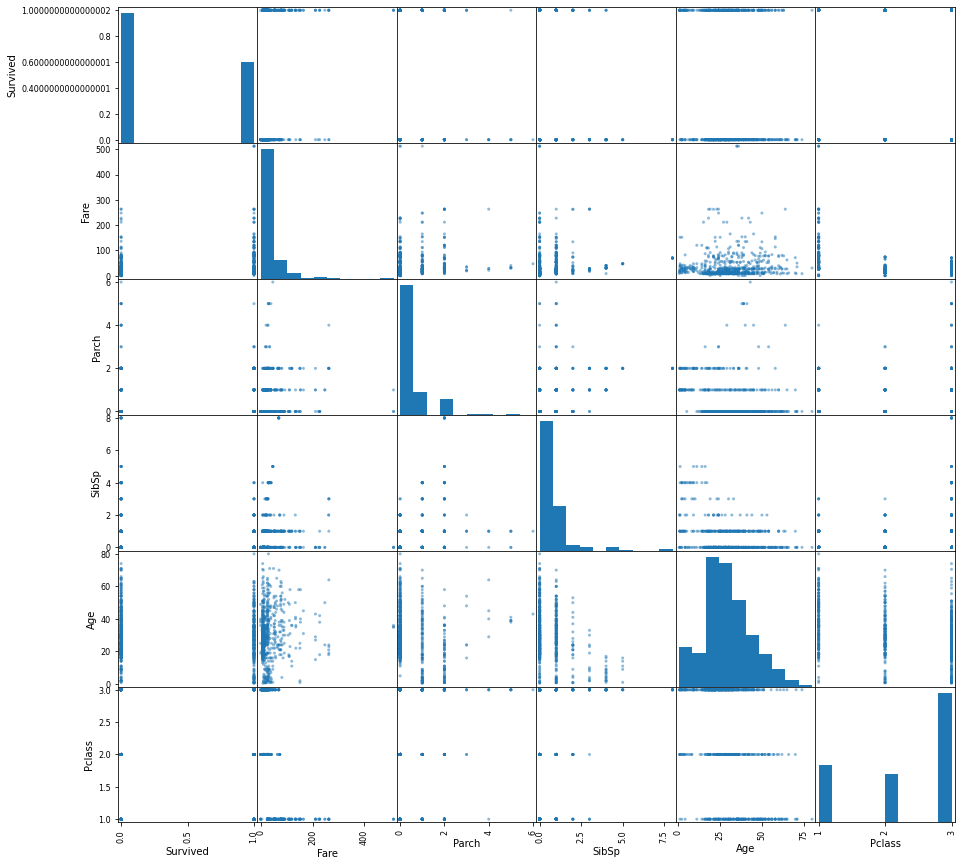

In [9]:
# Scatter matrix plots are used to plot every numerical attribute against every other 
# numerical attribute, plus a histogram of each numberial attribute
from pandas.plotting import scatter_matrix

# Here are just a few since 11*11=121 plots
attributes=["Survived", "Fare", "Parch", "SibSp", "Age", "Pclass"]
scatter_matrix(training_data[attributes], figsize=(15,15))

#### Create new attribute combinations

In [10]:
training_data["Fmembers"] = training_data["Parch"] + training_data["SibSp"]

# check out the new combinations
correlation_matrix = training_data.corr()
correlation_matrix["Survived"].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
Fmembers    0.016639
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

## Prepare the Data for Machine Learning Algorithms

We need to take care of the missing attributes and categorical attributes.

In [11]:
# Create the Labels
training_labels = training_data["Survived"].copy()
training_labels.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [12]:
# Drop the Target Value
training_data = training_data.drop("Survived", axis=1)
training_data.head()

Pclass     Sex   Age  SibSp  Parch     Fare  Fmembers
0       3    male  22.0      1      0   7.2500         1
1       1  female  38.0      1      0  71.2833         1
2       3  female  26.0      0      0   7.9250         0
3       1  female  35.0      1      0  53.1000         1
4       3    male  35.0      0      0   8.0500         0

In [13]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Fmembers  891 non-null    int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 48.9+ KB


In [14]:
# Let's start by fixing the missing 'Age' values by filling them in with the median.
# Note that this method computes and fills the median of ALL missing attribute values.

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

training_data_numerical_attributes = training_data.drop("Sex", axis=1)

imputer.fit(training_data_numerical_attributes)

# Compute median of each numerical attribute
imputer.statistics_
training_data_numerical_attributes.median().values

# Transform the training dataset by replacing missing values with the learned values
X = imputer.transform(training_data_numerical_attributes)

# Note that type(X) is numpy.ndarray

In [15]:
# Let's check that this worked by converting 'X' back into a pandas DataFrame object and looking
# info again.

training_data_transformed = pd.DataFrame(X, columns=training_data_numerical_attributes.columns, index=training_data_numerical_attributes.index) 
# ^ Note this is just to demonstrate, we don't use 'training_data_transformed' again.
training_data_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    float64
 1   Age       891 non-null    float64
 2   SibSp     891 non-null    float64
 3   Parch     891 non-null    float64
 4   Fare      891 non-null    float64
 5   Fmembers  891 non-null    float64
dtypes: float64(6)
memory usage: 41.9 KB


In [16]:
# Next we need to handle the categorical attributes
training_data_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    float64
 1   Age       891 non-null    float64
 2   SibSp     891 non-null    float64
 3   Parch     891 non-null    float64
 4   Fare      891 non-null    float64
 5   Fmembers  891 non-null    float64
dtypes: float64(6)
memory usage: 41.9 KB


In [17]:
# We only have the 'Sex' attribute we need to convert to a binary value.
training_data_categorical_attributes = training_data[["Sex"]]
training_data_categorical_attributes.head(10)

Sex
0    male
1  female
2  female
3  female
4    male
5    male
6    male
7    male
8  female
9  female

In [18]:
# Let's convert this using the OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
category_encoder = OneHotEncoder()
training_data_categorical_attributes_1hot = category_encoder.fit_transform(training_data_categorical_attributes)
training_data_categorical_attributes_1hot

<891x2 sparse matrix of type '<class 'numpy.float64'>'
	with 891 stored elements in Compressed Sparse Row format>

In [19]:
training_data_categorical_attributes_1hot.toarray()

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [20]:
category_encoder.categories_

[array(['female', 'male'], dtype=object)]

In [21]:
# I don't think this is exactly what we wanted, 
# I think it would be better to just have a 0 or 1 value, not a tuple.

# Different approach:
training_data_categorical_attributes["Sex"].replace('male', 0, inplace=True)
training_data_categorical_attributes["Sex"].replace('female', 1, inplace=True)
training_data_categorical_attributes.head(10)

Sex
0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    1
9    1

In [22]:
# This seems a lot better.

#### Custom Transformers

Here is a small transformer class that adds the combined attributes we created above.

The 'add_fmembers' hyperparameter will allow us to easily find out if adding this attribute helps the ML algorithm or not.

In [23]:
# Should we reset the data here? I think I should come back to this.

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

SibSp_index, Parch_index = 3, 4 # The column in X

class NumericalAttributesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, add_fmembers = True): # no *args or **kargs
        self.add_fmembers = add_fmembers
        
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        if self.add_fmembers:
            fmembers = X[:, SibSp_index] + X[:, Parch_index]
            return np.c_[X, fmembers]
        else:
            return np.c_[X]

class CategoricalAttributesTransformer(BaseEstimator, TransformerMixin):        
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        X["Sex"].replace('male', 0, inplace=True)
        X["Sex"].replace('female', 1, inplace=True)  
        return np.c_[X]
        
# Demo only:
#numerical_Attributes_Transformer = NumericalAttributesTransformer(add_fmembers=False)
#training_data_numerical_attributes = numerical_Attributes_Transformer.transform(training_data_numerical_attributes)

#### Transformation Pipelines

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [26]:
# Here is a small pipeline for the numerical attributes

numerical_attributes_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), # Fill blank values with most frequent
    ('numerical_attributes_transformer', NumericalAttributesTransformer(add_fmembers=True)),
    ('std_scaler', StandardScaler()), # Feature Scaling
])

#training_data_numerical_attributes_transformed = numerical_attributes_pipeline.fit_transform(training_data_numerical_attributes)
#training_data_numerical_attributes_transformed
# ^ Note that we don't use this result, we use the numerical pipeline below in the full pipeline

In [27]:
# Here is a small pipeline for the categorical attributes

categorical_attributes_pipeline = Pipeline([
    ('categorical_attributes_transformer', CategoricalAttributesTransformer()),
])

#training_data_categorical_attributes_transformed = categorical_attributes_pipeline.fit_transform(training_data_categorical_attributes)
#training_data_categorical_attributes_transformed
# ^ Note that we don't use this result, we use the categorical pipeline below in the data transformation pipeline

In [28]:
# Data transformation pipeline to apply all the transformations to the titanic data

from sklearn.compose import ColumnTransformer

numerical_attributes = list(training_data_numerical_attributes)
categorical_attributes = ["Sex"]

data_transformation_pipeline = ColumnTransformer([
    ('numerical_attributes_pipeline', numerical_attributes_pipeline, numerical_attributes),
    ('categorical_attributes_pipeline', categorical_attributes_pipeline, categorical_attributes),
])

training_data_prepared = data_transformation_pipeline.fit_transform(training_data)

In [29]:
# Let's turn this back into a Pandas DataFrame Object just to make sure everything worked.

training_data_prepared_data_frame = pd.DataFrame(training_data_prepared)

training_data_prepared_data_frame.head()

0         1         2         3         4         5         6    7
0  0.827377 -0.497793  0.432793 -0.473674 -0.502445  0.059160 -0.508282  0.0
1 -1.566107  0.715048  0.432793 -0.473674  0.786845  0.059160  0.776342  1.0
2  0.827377 -0.194583 -0.474545 -0.473674 -0.488854 -0.560975 -0.494741  1.0
3 -1.566107  0.487640  0.432793 -0.473674  0.420730  0.059160  0.411552  1.0
4  0.827377  0.487640 -0.474545 -0.473674 -0.486337 -0.560975 -0.492233  0.0

In [30]:
training_data_prepared_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       891 non-null    float64
 1   1       891 non-null    float64
 2   2       891 non-null    float64
 3   3       891 non-null    float64
 4   4       891 non-null    float64
 5   5       891 non-null    float64
 6   6       891 non-null    float64
 7   7       891 non-null    float64
dtypes: float64(8)
memory usage: 55.8 KB


## Select and Train a Model

### SGD Classifier
Let's start with a SGD Classifier

In [31]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(training_data_prepared, training_labels)

SGDClassifier(random_state=42)

In [32]:
# Let's see if this worked
some_person = training_data_prepared[0]
sgd_classifier.predict([some_person])

array([0], dtype=int64)

In [33]:
# This looks like it worked, the first passenger entry we had did not survive. (Survived == 0)

In [34]:
# Now lets use cross_val_score() to evaluate our SGDClassifier model
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_classifier, training_data_prepared, training_labels, cv=3, scoring="accuracy")

array([0.71717172, 0.75757576, 0.7979798 ])

In [35]:
# 74%-77% Accuracy isn't a bad start.
# But we need to use a confusion matrix to correctly evaluate the performance of our model (pg. 90)

In [36]:
# Get the training predictions
from sklearn.model_selection import cross_val_predict
# cross_val_predict works like cross_val_score but returns the predictions made on each test fold.

training_predictions = cross_val_predict(sgd_classifier, training_data_prepared, training_labels, cv=3)

In [37]:
# Now we are ready to get the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(training_labels, training_predictions)

array([[437, 112],
       [104, 238]], dtype=int64)

Remember the confusion matrix:

TN | FP

FN | TP

In this context, TN == Died, TP == Survived

In [38]:
# Now let's calculate the precision and recall of the classifier
from sklearn.metrics import precision_score, recall_score

# Precision: The accuracy of the positve predictions is called the precision of the classifier.
# precision = TP / (TP + FP)

print(precision_score(training_labels, training_predictions))

# Recall: The senesitivity or the true positive rate (TPR) is the ratio of positive instances that are # correctly detected by the classifier
# recall = TP / (TP + FN)

print(recall_score(training_labels, training_predictions))

0.68
0.695906432748538


In [39]:
# Now let's calculate the F1 score
from sklearn.metrics import f1_score
f1_score(training_labels, training_predictions)

0.6878612716763006

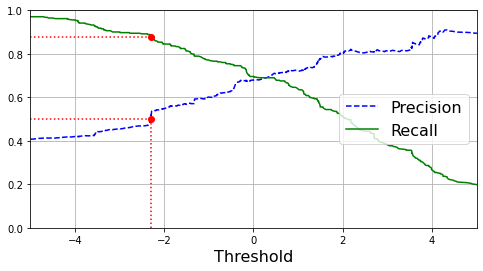

In [40]:
# Let's do the following cross-validation to decide on which threshold value to use
training_scores_sgd = cross_val_predict(sgd_classifier, training_data_prepared, training_labels, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(training_labels, training_scores_sgd)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-5, 5, 0, 1])             

recall_50_precision = recalls[np.argmax(precisions >= 0.50)]
threshold_50_precision = thresholds[np.argmax(precisions >= 0.50)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_50_precision, threshold_50_precision], [0., 0.5], "r:")                 
plt.plot([-5, threshold_50_precision], [0.5, 0.5], "r:")                                
plt.plot([-5, threshold_50_precision], [recall_50_precision, recall_50_precision], "r:")
plt.plot([threshold_50_precision], [0.5], "ro")                                             
plt.plot([threshold_50_precision], [recall_50_precision], "ro")                             
plt.show()

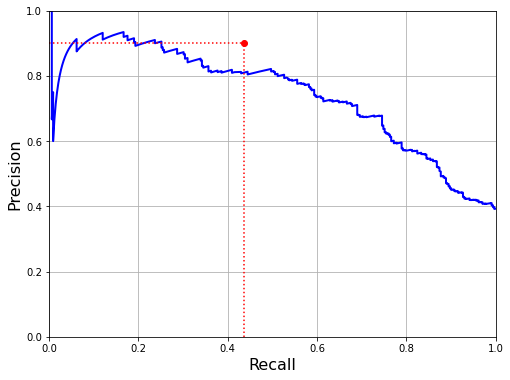

In [41]:
# We can also plot precision vs. recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

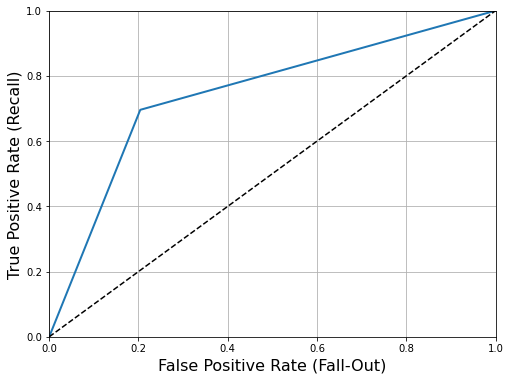

In [42]:
# Next let's plot the ROC Curve
from sklearn.metrics import roc_curve

fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(training_labels, training_predictions)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0,1], 'k--') # Dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_sgd, tpr_sgd)
plt.show()

In [43]:
# Next let's computer the ROC AUC (Area under the Curve)
from sklearn.metrics import roc_auc_score
roc_auc_score(training_labels, training_scores_sgd)

0.80535050437265

### RandomForestClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

Next we’ll try a RandomForestClassifier and compare its ROC curve and ROC AUC Score

Note that the RandomForestClassifier doesn't have a decision_function() instead we need to use its predict_proba() function.

Generally SKLearn classifiers have one or the other or both.

In [44]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier(random_state=42)
training_probabilities_rfc = cross_val_predict(random_forest_classifier, training_data_prepared, training_labels, cv=3, method="predict_proba")

In [45]:
# The roc_curve() function expects labels and scores but instead of scores we can give it probabilities
training_scores_rfc = training_probabilities_rfc[:,1] # score = proba of positive class
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(training_labels, training_scores_rfc)

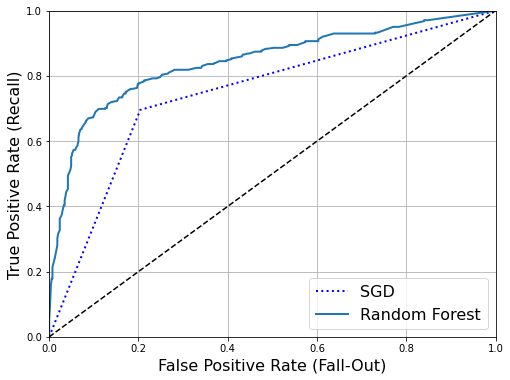

In [46]:
# Now we can plot the ROC Curve for the RF Classifier and compare it to the SGD Classifier
plt.figure(figsize=(8, 6))
plt.plot(fpr_sgd, tpr_sgd, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_rfc, tpr_rfc, "Random Forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [47]:
# From our graph we can see the RandomForestClassifier is superior to the SGDClassifier 
# because the ROC Curve is closer to the top left corner and has a greater AUC value.
roc_auc_score(training_labels, training_scores_rfc)

0.8436285005166224

### KNeighborsClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

In [48]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier()

training_probabilities_knn = cross_val_predict(knn_classifier, training_data_prepared, training_labels, cv=3, method="predict_proba")

training_scores_knn = training_probabilities_knn[:,1] # score = proba of positive class
fpr_knn, tpr_knn, thresholds_knn = roc_curve(training_labels, training_scores_knn)

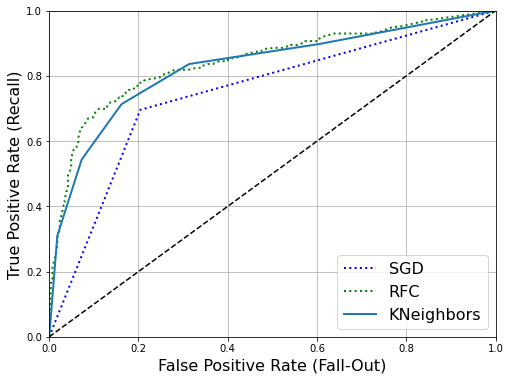

In [49]:
# Now we can plot the ROC Curve for the KNN Classifier and compare it to the SGD and RF Classifiers
plt.figure(figsize=(8, 6))
plt.plot(fpr_sgd, tpr_sgd, "b:", linewidth=2, label="SGD")
plt.plot(fpr_rfc, tpr_rfc, "g:", linewidth=2, label="RFC")
plot_roc_curve(fpr_knn, tpr_knn, "KNeighbors")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [50]:
roc_auc_score(training_labels, training_scores_knn)

0.827109896782028

In [51]:
# KNN is slightly worse than RFC

### GaussianProcessClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html#sklearn.gaussian_process.GaussianProcessClassifier

In [52]:
from sklearn.gaussian_process import GaussianProcessClassifier

gp_classifier = GaussianProcessClassifier()

training_probabilities_gp = cross_val_predict(gp_classifier, training_data_prepared, training_labels, cv=3, method="predict_proba")

training_scores_gp = training_probabilities_gp[:,1] # score = proba of positive class
fpr_gp, tpr_gp, thresholds_gp = roc_curve(training_labels, training_scores_gp)

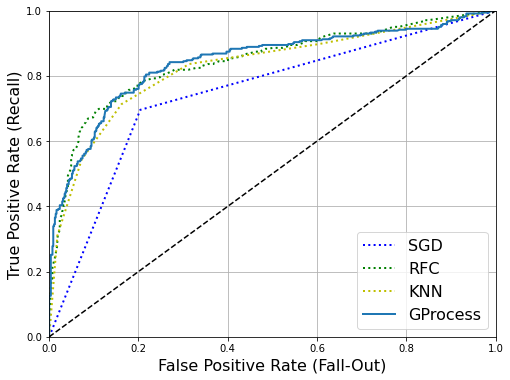

In [53]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_sgd, tpr_sgd, "b:", linewidth=2, label="SGD")
plt.plot(fpr_rfc, tpr_rfc, "g:", linewidth=2, label="RFC")
plt.plot(fpr_knn, tpr_knn, "y:", linewidth=2, label="KNN")
plot_roc_curve(fpr_gp, tpr_gp, "GProcess")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [54]:
roc_auc_score(training_labels, training_scores_gp)

0.8438868117470361

In [55]:
# The Guassian Process Classifier ROC AUC score is about the same as the RFC Classifier

#### MLPClassifier (Neural Network)

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

In [56]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier()

training_probabilities_mlp = cross_val_predict(mlp_classifier, training_data_prepared, training_labels, cv=5, method="predict_proba")

training_scores_mlp = training_probabilities_mlp[:,1] # score = proba of positive class
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(training_labels, training_scores_mlp)

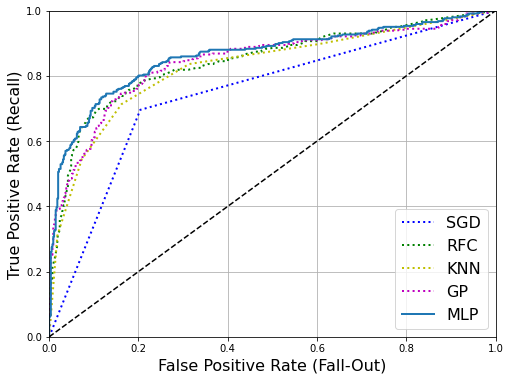

In [57]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_sgd, tpr_sgd, "b:", linewidth=2, label="SGD")
plt.plot(fpr_rfc, tpr_rfc, "g:", linewidth=2, label="RFC")
plt.plot(fpr_knn, tpr_knn, "y:", linewidth=2, label="KNN")
plt.plot(fpr_gp, tpr_gp, "m:", linewidth=2, label="GP")
plot_roc_curve(fpr_mlp, tpr_mlp, "MLP")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [58]:
roc_auc_score(training_labels, training_scores_mlp)

0.8614573014199128

### Select a Model Conclusion

While the MLP Classifier had the highest AUC score, it wasn't much higher than the RFC or GP Classifiers.

As such, I don't think it is worth it to use a much more powerful model to justify a 1% improvement over a simpler model.

As such, I am going to move ahead with the RFC classifier and focus on tuning it's hyperparameters next.

## Fine-Tune Your Model

### GridSearchCV

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html


In [59]:
from sklearn.model_selection import GridSearchCV

parameter_grid = {
    'n_estimators': [10, 30, 100, 300],
    'max_depth': [1, 3, 10, 30, 100],
    'min_samples_split': [1, 3, 10, 30],
    'min_samples_leaf': [1, 3, 10, 30],
    'max_features': [1, 3, 10, 30, 100],
    'bootstrap': [True, False],
    'random_state': [42]
}

random_forest_classifier = RandomForestClassifier()

grid_search = GridSearchCV(
    estimator = random_forest_classifier, 
    param_grid = parameter_grid, 
    cv = 3, 
    n_jobs = -1, 
    verbose = 2
)

grid_search.fit(training_data_prepared, training_labels)

Fitting 3 folds for each of 3200 candidates, totalling 9600 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 836 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 1968 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 3428 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 4528 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 6452 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 8880 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9569 out of 9600 | elapsed:  1.1min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 9600 out of 9600 | elapsed:  1.1min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [1, 3, 10, 30, 100],
                         'max_features': [1, 3, 10, 30, 100],
                         'min_samples_leaf': [1, 3, 10, 30],
                         'min_samples_split': [1, 3, 10, 30],
                         'n_estimators': [10, 30, 100, 300],
                         'random_state': [42]},
             verbose=2)

In [60]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 1,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 100,
 'random_state': 42}

In [61]:
grid_search.best_score_

0.8338945005611672

In [62]:
# This doesn't look all that promising, maybe we should zero in on best parameters and create a distribution closer to those.

In [63]:
parameter_grid = {
    'n_estimators': [80, 90, 100, 110, 120],
    'max_depth': [24, 26, 28, 30, 32, 34, 36],
    'min_samples_split': [6, 8, 10, 12, 14],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': [1, 2, 3, 4, 5],
    'bootstrap': [True, False],
    'random_state': [42]
}

random_forest_classifier = RandomForestClassifier()

grid_search = GridSearchCV(
    estimator = random_forest_classifier, 
    param_grid = parameter_grid, 
    cv = 3, 
    n_jobs = -1, 
    verbose = 2
)

grid_search.fit(training_data_prepared, training_labels)

Fitting 3 folds for each of 7000 candidates, totalling 21000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 1930 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 2820 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 3874 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 5088 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6466 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 8004 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 9706 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 11568 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 13594 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 15780 tasks

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [24, 26, 28, 30, 32, 34, 36],
                         'max_features': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [6, 8, 10, 12, 14],
                         'n_estimators': [80, 90, 100, 110, 120],
                         'random_state': [42]},
             verbose=2)

In [64]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 24,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 110,
 'random_state': 42}

In [65]:
grid_search.best_score_

0.8395061728395062

In [66]:
# This isn't an improvement (0.2% improvement) over the initial best parameters we found.

### Analyze the Best Models and Their Error

### Feature Importance

In [67]:
# Let's look at the relative importance of each attribute for making accurate predictions
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attributes = ["Fmembers"]
category_encoder = data_transformation_pipeline.named_transformers_["categorical_attributes_pipeline"]
category_attributes = ["Sex"]
attributes = numerical_attributes + extra_attributes + category_attributes
print(sorted(zip(feature_importances, attributes), reverse=True))

[(0.3171671644864373, 'Sex'), (0.1972279906589765, 'Age'), (0.1620979549807632, 'Fmembers'), (0.15098528166892008, 'Fare'), (0.09128394834012139, 'Pclass'), (0.04667474749742113, 'Fmembers'), (0.021790991004203095, 'SibSp'), (0.012771921363157374, 'Parch')]


In [68]:
# Let's create a pipeline to select the most important 'k' features

def indices_of_top_k(array, k):
    return np.sort(np.argpartition(np.array(array), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]
    
# Note that this feature selector assumes you have already computed the feature importances

In [69]:
k = 6
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([0, 1, 4, 5, 6, 7], dtype=int64)

In [70]:
np.array(attributes)[top_k_feature_indices]

array(['Pclass', 'Age', 'Fare', 'Fmembers', 'Fmembers', 'Sex'],
      dtype='<U8')

In [71]:
# Let's double check that these are indeed the top k features:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.3171671644864373, 'Sex'),
 (0.1972279906589765, 'Age'),
 (0.1620979549807632, 'Fmembers'),
 (0.15098528166892008, 'Fare'),
 (0.09128394834012139, 'Pclass'),
 (0.04667474749742113, 'Fmembers')]

### Feature Importance Pipeline

In [72]:
# Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', data_transformation_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [73]:
# Let's test that this is working.
# To check, let's look at the features of the first 3 instances and compare them to the top k features

training_data_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(training_data)

In [74]:
training_data_prepared_top_k_features[0:3]

array([[ 0.82737724, -0.49779327, -0.50244517,  0.05915988, -0.50828223,
         0.        ],
       [-1.56610693,  0.71504807,  0.78684529,  0.05915988,  0.77634215,
         1.        ],
       [ 0.82737724, -0.19458293, -0.48885426, -0.56097483, -0.4947405 ,
         1.        ]])

In [75]:
training_data_prepared[0:3, top_k_feature_indices]

array([[ 0.82737724, -0.49779327, -0.50244517,  0.05915988, -0.50828223,
         0.        ],
       [-1.56610693,  0.71504807,  0.78684529,  0.05915988,  0.77634215,
         1.        ],
       [ 0.82737724, -0.19458293, -0.48885426, -0.56097483, -0.4947405 ,
         1.        ]])

In [76]:
# They match, looks good.

## Full Pipeline

A single pipeline that does the full data preparation plus the final prediction

In [77]:
prepare_and_select_and_predict_pipeline = Pipeline([
    ('preparation', data_transformation_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('random_forest', RandomForestClassifier(**grid_search.best_params_)) # These params are from above
])

prepare_and_select_and_predict_pipeline.fit(training_data, training_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('numerical_attributes_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('numerical_attributes_transformer',
                                                                   NumericalAttributesTransformer()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare',
                                                   'Fmembers']),
                                                 ('categorical_attributes_pipel...
                               

In [78]:
# Let's try the full pipeline on a few instances:

some_data = training_data.iloc[:4]
some_labels = training_labels.iloc[:4]

print("Predictions:\t", prepare_and_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [0 1 1 1]
Labels:		 [0, 1, 1, 1]


In [79]:
# We can see that the full pipeline is working.

### Explore some data preparation automation

In [80]:
param_grid = [{
    'preparation__numerical_attributes_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_and_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs = -1)
grid_search_prep.fit(training_data, training_labels)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.2s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('numerical_attributes_pipeline',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('numerical_attributes_transformer',
                                                                                          NumericalAttributesTransformer()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['Pclass',
                                     

In [81]:
grid_search_prep.best_params_

{'feature_selection__k': 6,
 'preparation__numerical_attributes_pipeline__imputer__strategy': 'median'}

In [82]:
# Measure accuracy on the training set
from sklearn.metrics import accuracy_score

predictions = grid_search_prep.predict(training_data)
accuracy_score(training_labels, predictions)

0.9371492704826038

In [83]:
# That's a lot better, but we could very likely just be overfitting the training data now.

In [84]:
# Let's look at the F1 score:
f1_score(training_labels, predictions, average="macro")

0.932620320855615

In [85]:
# Let's look at the ROC AUC score:
probabilities = cross_val_predict(grid_search_prep, training_data, training_labels, cv=3, method="predict_proba")
scores = probabilities[:,1] # score = proba of positive class
fpr, tpr, thresholds = roc_curve(training_labels, scores)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  89 out of 120 | elapsed:    1.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.6s finished


In [86]:
roc_auc_score(training_labels, scores)

0.8535029133245988

In [87]:
# This isn't any better than when we began hyperparameter tuning for this model...